In [1]:
import numpy as np
from numpy import *
import lab2_proto as proto
import lab2_tools as tools
import prondict as pron
from lab2_proto import *
from lab2_tools import *
from prondict import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

In [3]:
pro = pron.prondict
isolated = {}
for digit in pro.keys():
    isolated[digit] = ['sil'] + pro[digit] + ['sil']

In [4]:
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
pro = pron.prondict
isolated = {}
for digit in pro.keys():
    isolated[digit] = ['sil'] + pro[digit] + ['sil']
wordHMMs = {}
wordHMMs['o'] = proto.concatHMMs(phoneHMMs, isolated['o'])
for uterance in isolated:
    wordHMMs[uterance] = concatHMMs(phoneHMMs,isolated[uterance])
# print(wordHMMs['o'])

In [5]:
example = np.load('lab2_example.npz',allow_pickle=True)['example'].item()

In [6]:
list(example.keys())
example['lmfcc'].shape
example['obsloglik'].shape

(71, 9)

(71, 13)
(9, 13)
(71, 9)


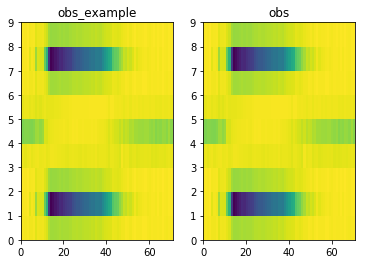

In [7]:
obsloglik = tools.log_multivariate_normal_density_diag(example['lmfcc'],wordHMMs['o']['means'],wordHMMs['o']['covars'])
print(example['lmfcc'].shape)
print(wordHMMs['o']['means'].shape)
print(obsloglik.shape)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['obsloglik'].T)
ax[0].set_title('obs_example')
ax[1].set_title('obs')
ax[1].pcolormesh(obsloglik.T)
plt.show()


## What can you say about the figure? Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence.
The figure is exactly the same as in example\['obsloglik'\].  The components '1','7' give the lowest likelihood in timesteps between 10-40.  The dark areas represent the frames form the 10th to 40th are unlikely to be slience which are the 7th and 1st componet of the word HMM.

## verify forward

In [8]:
log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])
log_alpha,_ = forward(obsloglik,log_startprob,log_transmat)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['logalpha'].T)
ax[0].set_title('obs logalpha_example')
ax[1].set_title('obs logalpha')
ax[1].pcolormesh(log_alpha.T)
plt.show()

ValueError: too many values to unpack (expected 2)

## Compare the results obtained from the models trained on a single speaker or all the training speakers.

### one speaker

In [9]:
data = np.load('lab2_data.npz',allow_pickle=True)['data']

In [10]:
maxLikelihoods = []
maxll = -inf
maxll_model = ''

for sample in tqdm(data):
    digit = sample['digit']
    maxll = -inf 
    dic = {}
    for hmm in wordHMMs:
        obsll = log_multivariate_normal_density_diag(sample['lmfcc'],
                                                       wordHMMs[hmm]['means'],
                                                       wordHMMs[hmm]['covars'])
        log_startprob_tmp = np.log(wordHMMs[hmm]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm]['transmat'])

        _,obs_seq_ll = forward(obsll,log_startprob_tmp,log_transmat_tmp)

        if obs_seq_ll > maxll:
            maxll = obs_seq_ll
            maxll_model = hmm

    dic['gender'] = sample['gender']
    dic['digit'] = digit 
    dic['model'] = maxll_model
    dic['max_ll'] = int(maxll)
    
    maxLikelihoods.append(dic)

0%|          | 0/44 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [11]:
print("man acc:",12/22)
print("woman acc:",1)
maxLikelihoods

man acc:0.5454545454545454
woman acc:1


[]

### All speaker

In [12]:
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
pro = pron.prondict
isolated = {}
for digit in pro.keys():
    isolated[digit] = ['sil'] + pro[digit] + ['sil']
wordHMMs = {}
wordHMMs['o'] = proto.concatHMMs(phoneHMMs, isolated['o'])
for uterance in isolated:
    wordHMMs[uterance] = concatHMMs(phoneHMMs,isolated[uterance])

In [13]:
maxLikelihoods = []
maxll = -inf
maxll_model = ''

for sample in tqdm(data):
    digit = sample['digit']
    maxll = -inf 
    dic = {}
    for hmm in wordHMMs:
        obsll = log_multivariate_normal_density_diag(sample['lmfcc'],
                                                       wordHMMs[hmm]['means'],
                                                       wordHMMs[hmm]['covars'])
        log_startprob_tmp = np.log(wordHMMs[hmm]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm]['transmat'])

        _,obs_seq_ll = forward(obsll,log_startprob_tmp,log_transmat_tmp)

        if obs_seq_ll > maxll:
            maxll = obs_seq_ll
            maxll_model = hmm

    dic['gender'] = sample['gender']
    dic['digit'] = digit 
    dic['model'] = maxll_model
    dic['max_ll'] = int(maxll)
    
    maxLikelihoods.append(dic)

0%|          | 0/44 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [14]:
print("man acc:",1)
print("woman acc:",21/22)
maxLikelihoods

man acc:1
woman acc:0.9545454545454546


[]

## Viterbi

In [15]:
viterbi_loglik, viterbi_path = viterbi(obsloglik,log_startprob,log_transmat)
print(viterbi_loglik,viterbi_path)
print(example['vloglik'],example['vpath'])


-5974.211288357338[0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]
-5974.211288357338[0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]


In [16]:
plt.pcolormesh(np.ma.masked_invalid(log_alpha).T)
plt.plot( np.arange(len(viterbi_path)),viterbi_path)
plt.title("Path overlayed on log_alpha")
plt.plot()

NameError: name 'log_alpha' is not defined

In [17]:
maxLikelihoods = []
maxll = -inf
maxll_model = ''

for sample in tqdm(data):
    digit = sample['digit']
    maxll = -inf 
    dic = {}
    for hmm in wordHMMs:
        obsll = log_multivariate_normal_density_diag(sample['lmfcc'],
                                                       wordHMMs[hmm]['means'],
                                                       wordHMMs[hmm]['covars'])
        log_startprob_tmp = np.log(wordHMMs[hmm]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm]['transmat'])

        obs_seq_ll,_ = viterbi(obsll,log_startprob_tmp,log_transmat_tmp)

        if obs_seq_ll > maxll:
            maxll = obs_seq_ll
            maxll_model = hmm

    dic['gender'] = sample['gender']
    dic['digit'] = digit 
    dic['model'] = maxll_model
    dic['max_ll'] = int(maxll)
    
    maxLikelihoods.append(dic)

100%|██████████| 44/44 [00:12<00:00,  3.79it/s]


In [18]:
print("man acc",12/22)
maxLikelihoods

man acc0.5454545454545454


[{'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -6477},
 {'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -5822},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -7767},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -7380},
 {'gender': 'man', 'digit': '1', 'model': '1', 'max_ll': -6614},
 {'gender': 'man', 'digit': '1', 'model': '1', 'max_ll': -6783},
 {'gender': 'man', 'digit': '2', 'model': '2', 'max_ll': -6005},
 {'gender': 'man', 'digit': '2', 'model': '2', 'max_ll': -7206},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -6963},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -7743},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -6830},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -6799},
 {'gender': 'man', 'digit': '5', 'model': '5', 'max_ll': -7287},
 {'gender': 'man', 'digit': '5', 'model': '5', 'max_ll': -6625},
 {'gender': 'man', 'digit': '6', 'model': '6', 'max_ll': -7726},
 {'gender': 'man', 'digit

## Verify Backward

In [19]:
beta,logll= backward(obsloglik,log_startprob,log_transmat)

ValueError: too many values to unpack (expected 2)

In [20]:
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['logbeta'].T)
ax[0].set_title('obs loggamma_example')
ax[1].set_title('obs logbeta')
ax[1].pcolormesh(beta.T)
plt.show()

NameError: name 'beta' is not defined

In [21]:
print(logll)
print(example['loglik'])

NameError: name 'logll' is not defined

## HMM Retraining

### verify gamma

In [22]:
loggamma=statePosteriors(log_alpha, beta)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['loggamma'].T)
ax[0].plot(example['vpath'])
ax[0].set_title('obs loggamma_example')
ax[1].set_title('obs loggamma')
ax[1].plot(viterbi_path)
ax[1].pcolormesh(loggamma.T)
plt.show()

NameError: name 'log_alpha' is not defined

### Compare HMM and GMM posteriors. What is the difference? Why?

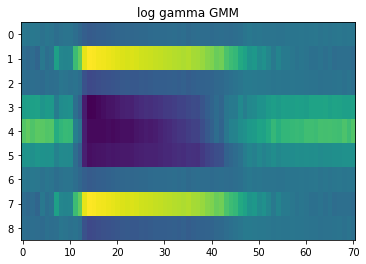

In [23]:
X = example['lmfcc']

hmm_model = wordHMMs['o']
obs_ll= log_multivariate_normal_density_diag(X, hmm_model['means'],hmm_model['covars'])

gamma_gmm = obs_ll/obs_ll.sum(1)[:,np.newaxis]

plt.imshow(np.log(gamma_gmm).T, interpolation='nearest', aspect='auto')
plt.title("log gamma GMM")
plt.show()

### Now sum the HMM posteriors (in linear domain) for each state along the time axis. What is the meaning the the values you obtain? What about summing over both states and time steps? Compare this number to the length of the observation sequence

In [24]:
def EM(wordHMM,X,n_iters):
    probs=[]
    ll=0
    iters=0
    for i in range(n_iters):
        #E
        obsloglik = log_multivariate_normal_density_diag(X, wordHMM['means'], wordHMM['covars']) 
        logalphas,_ = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        logbetas,_ = backward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        # M
        loggammas = statePosteriors(logalphas, logbetas)
        wordHMM['means'], wordHMM['covars'] = updateMeanAndVar(X, loggammas)
        pre_ll=ll
        ll=logsumexp(logalphas[-1])
        if np.allclose(ll, pre_ll):
            iters=i
            break
        probs.append(ll)
    
    return wordHMM,probs,iters

In [25]:
print(data[10]['digit'])
plt.plot(EM(wordHMMs['4'],data[10]['lmfcc'],10)[1])
plt.show()

4


ValueError: too many values to unpack (expected 2)

In [26]:
for digit in wordHMMs.keys():
    hmm = wordHMMs[digit].copy()
     # 'four'
    result = EM(hmm,data[10]['lmfcc'],20)
    plt.plot(result[1], label=digit)
    print(digit,":",result[2]," iterations")
    
plt.xlabel('Iteration')
plt.ylabel('log likelihood')
plt.legend()
plt.show()

ValueError: too many values to unpack (expected 2)